In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime



In [85]:
df = pd.read_csv('/content/drive/MyDrive/flattened_power_5.csv')
df.head()


,date,time,power
0,01-12-2021,00:00:00,465.29
1,01-12-2021,00:15:00,457.44
2,01-12-2021,00:30:00,450.22
3,01-12-2021,00:45:00,441.40
4,01-12-2021,01:00:00,431.86


<ipython-input-102-60d4bcd1a26e>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Axes: xlabel='None,hour'>

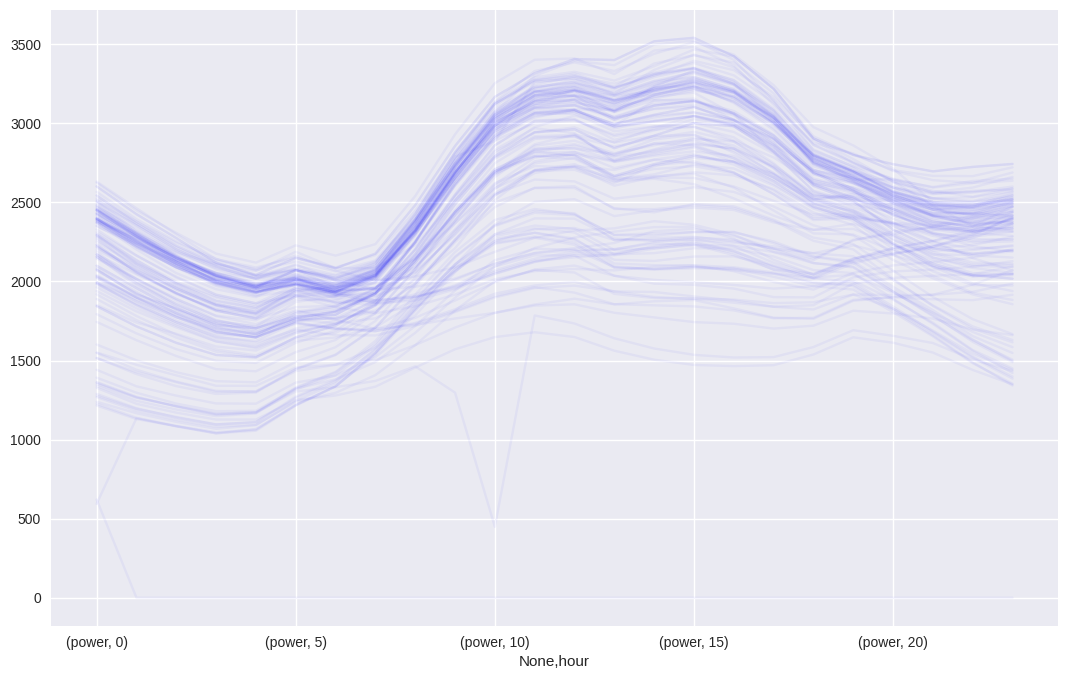

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')


df_uci =  df[7394:18913].copy()

df_uci['datetime'] = pd.to_datetime(df_uci['date'] + ' '+ df_uci['time'])
del df_uci['date'],df_uci['time']
df_uci = df_uci.set_index('datetime')


# For simplication,
# I will resample so that each row
# represents a whole hour
df_uci_hourly = df_uci.resample('H').sum()
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date

df_uci_pivot = df_uci_hourly.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()

# Filter out dates that are not in the original dataset
mask = df_uci_pivot.index.isin(df_uci.index.date)
df_uci_pivot = df_uci_pivot[mask]
X = df_uci_pivot.values.copy()

df_uci_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.04)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

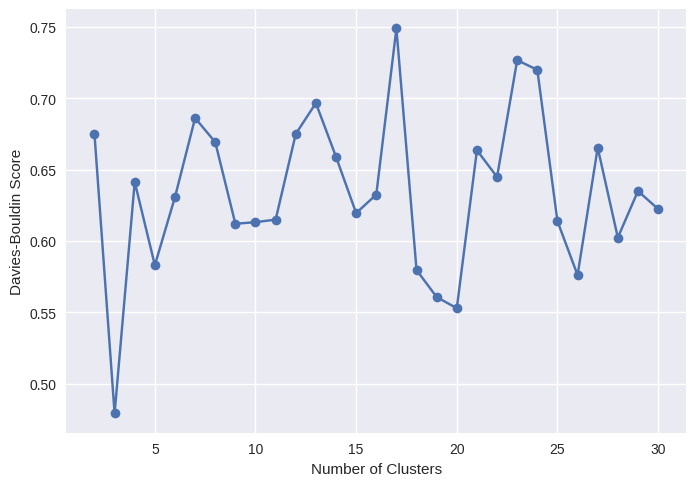

In [87]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score

davies_scores = []
n_cluster_list = np.arange(2,31).astype(int)


    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    davies_scores.append(davies_bouldin_score(X, kmeans.labels_))
    
# Plot the Davies-Bouldin scores vs number of clusters
import matplotlib.pyplot as plt

plt.plot(n_cluster_list, davies_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

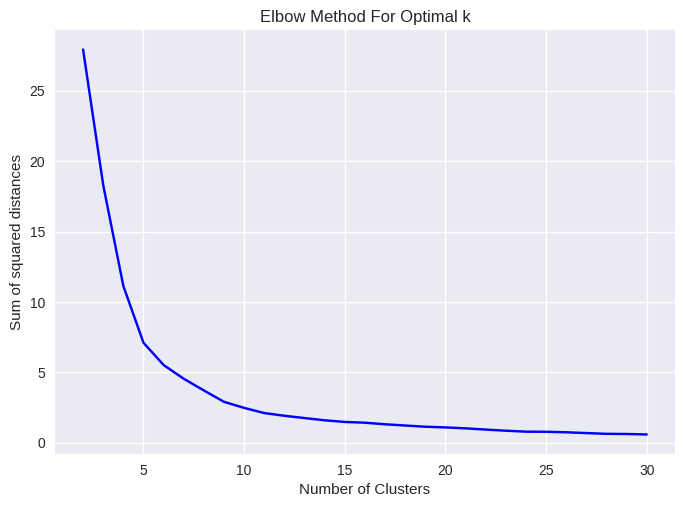

In [88]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

sum_of_squared_distances = []
n_cluster_list = np.arange(2,31).astype(int)

X = df_uci_pivot.values.copy()

# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(X)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(n_cluster_list, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0, 'hour')

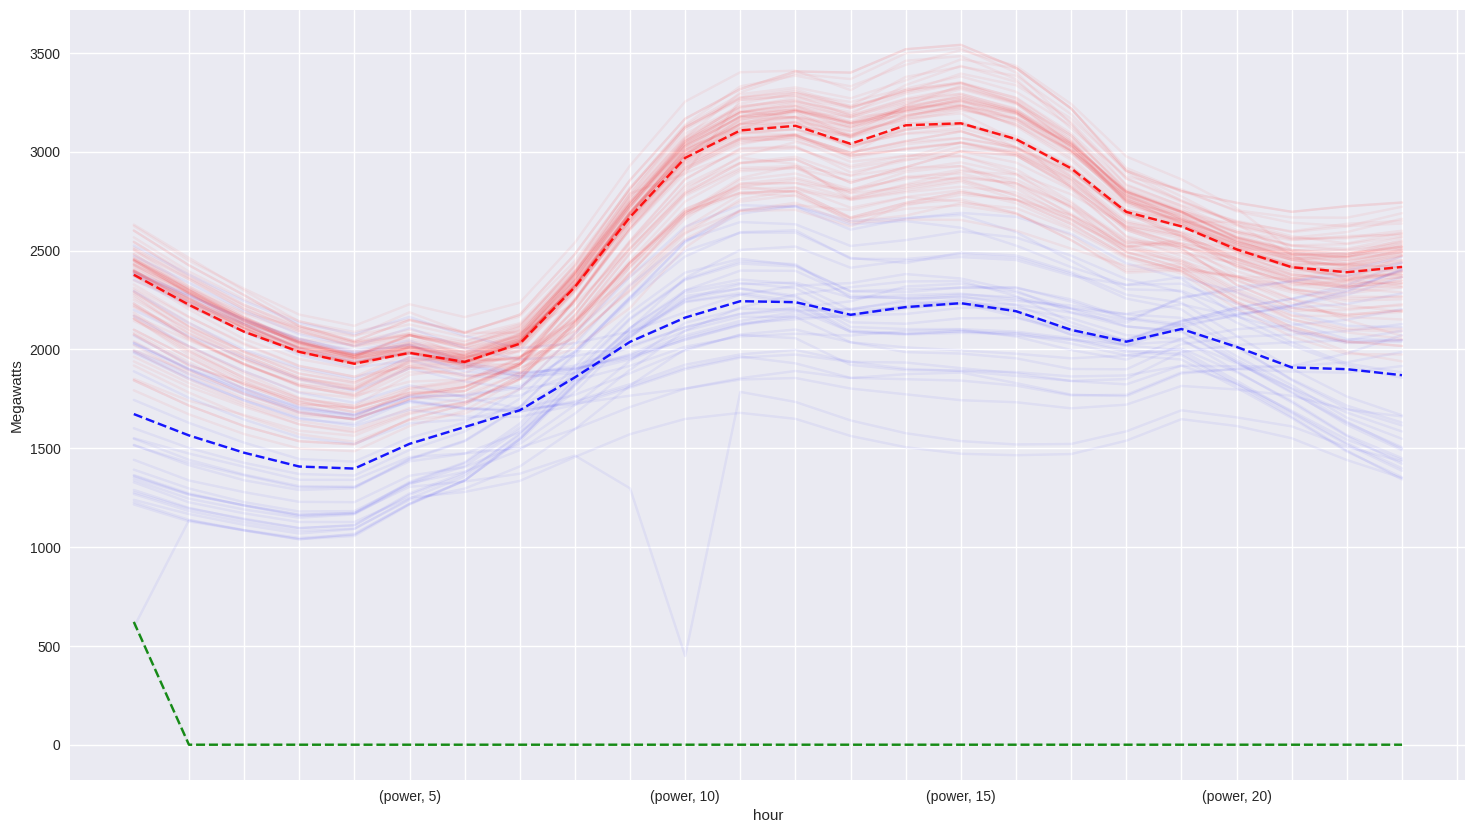

In [103]:

kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot= df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.05, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('Megawatts')
ax.set_xlabel('hour')



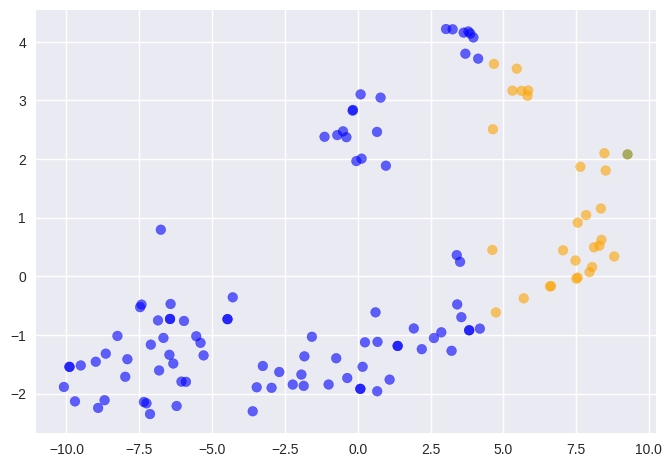

In [95]:

from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=df_uci_pivot.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )


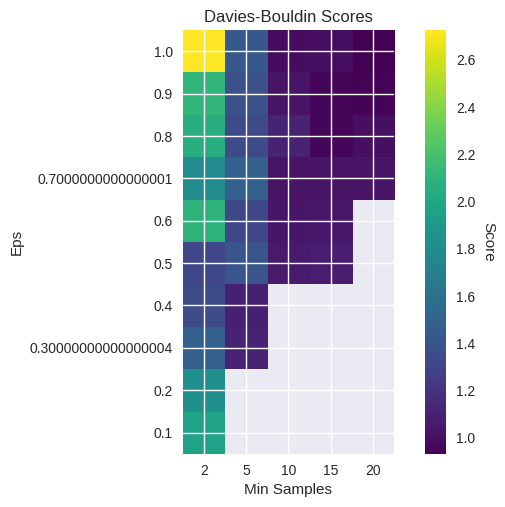

In [79]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

davies_scores = []
eps_list = np.arange(0.1, 1.1, 0.1)
min_samples_list = [2, 5, 10, 15, 20]

X = df_uci_pivot.values.copy()
    
# Very important to scale!
sc = StandardScaler()
X = sc.fit_transform(X)

for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_found = dbscan.fit_predict(X)
        if len(set(cluster_found)) > 1:
            davies_scores.append(davies_bouldin_score(X, cluster_found))
        else:
            davies_scores.append(np.nan)
    
# Plot the Davies-Bouldin scores vs eps and min_samples
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(np.array(davies_scores).reshape(len(eps_list), len(min_samples_list)), cmap='viridis', origin='lower')

ax.set_xticks(np.arange(len(min_samples_list)))
ax.set_yticks(np.arange(len(eps_list)))
ax.set_xticklabels(min_samples_list)
ax.set_yticklabels(eps_list)
ax.set_xlabel('Min Samples')
ax.set_ylabel('Eps')
ax.set_title('Davies-Bouldin Scores')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Score', rotation=-90, va="bottom")
plt.show()


Text(0.5, 0, 'hour')

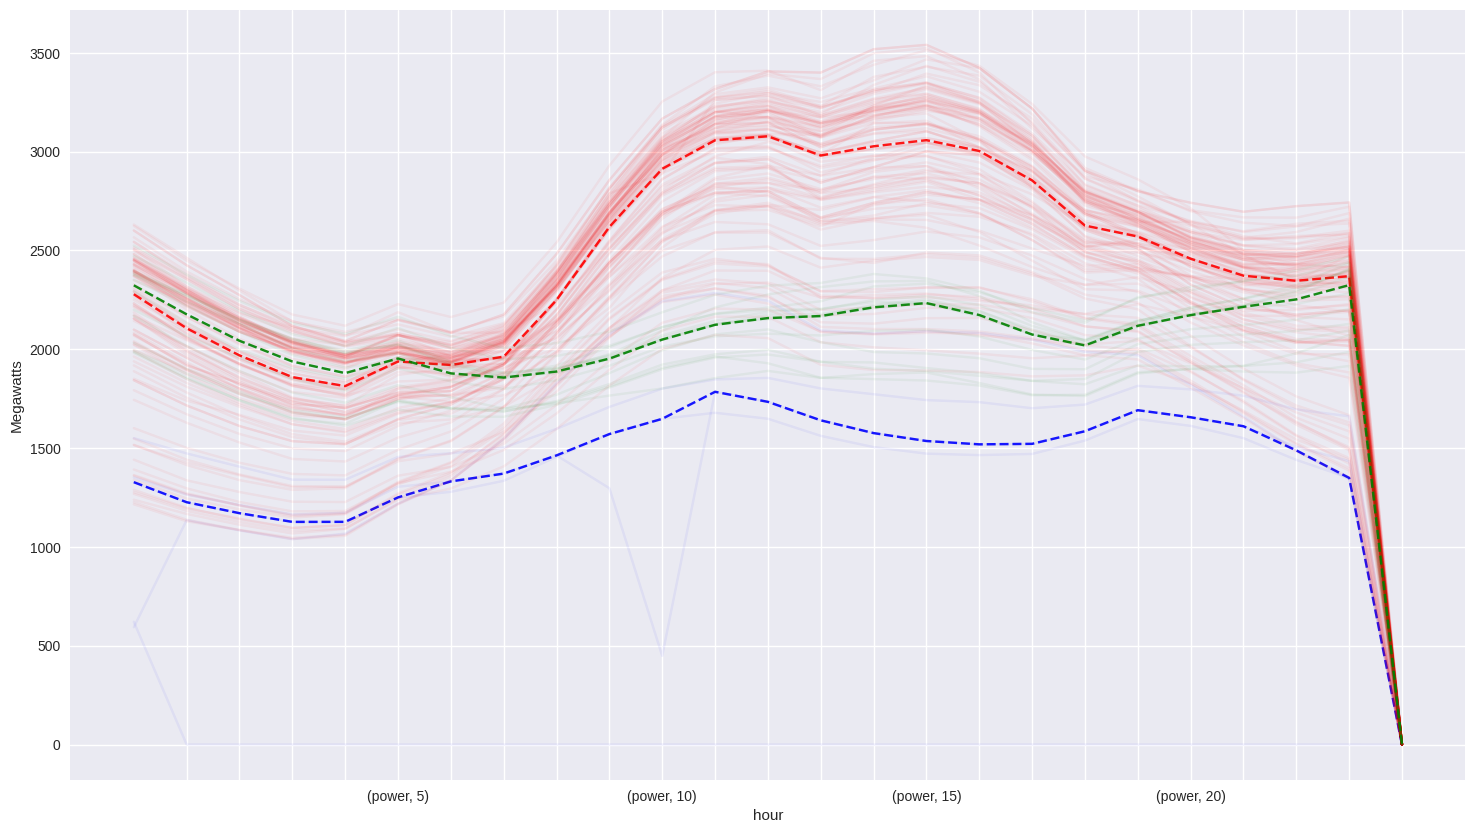

In [104]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# Scale the data
sc = MinMaxScaler()
X = sc.fit_transform(df_uci_pivot.values)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=7)
cluster_found = dbscan.fit_predict(X)

# Assign the clusters to the dataframe and plot the results
df_uci_pivot['cluster'] = cluster_found
fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot['cluster'].unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot[df_uci_pivot['cluster']==cluster].T.plot(
        ax=ax, legend=False, alpha=0.05, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot[df_uci_pivot['cluster']==cluster].median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('Megawatts')
ax.set_xlabel('hour')



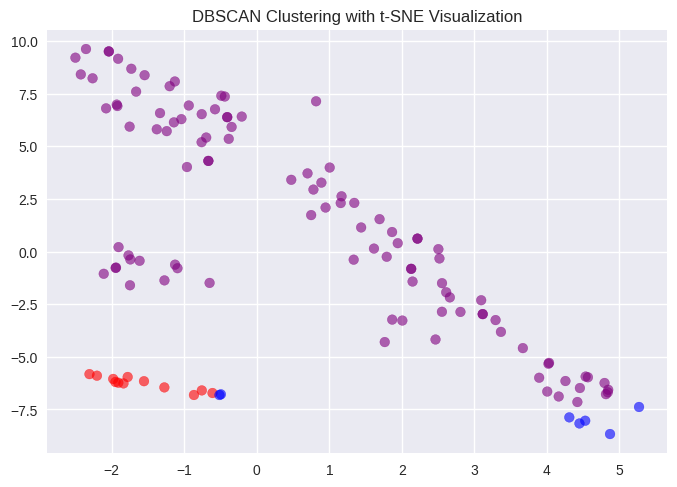

In [98]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.colors

dbscan = DBSCAN(eps=0.3, min_samples=7)
cluster_found = dbscan.fit_predict(X)

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

n_clusters = len(set(cluster_found)) - (1 if -1 in cluster_found else 0)
color_list = ['blue','red','green', 'purple', 'orange', 'gray', 'pink', 'brown', 'olive']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    cluster_values, color_list[:n_clusters])

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=cluster_found,
    cmap=cmap, 
    alpha=0.6, 
    )

plt.title('DBSCAN Clustering with t-SNE Visualization')
plt.show()
